# Lab 1

Group Members:

- Parker

- Suma 

- Chris

- Oliver

## Introduction

**Why is it important to find this kind of bias in machine learning models?**

TODO: Answer this

**Why will the type of investigation I am performing be relevant to other researchers or practitioners?**

TODO: Answer this

For example, we are trying to answer if a romantic comedy is ranked as more positive or if a horror movie is ranked as more negative. 

To do this, we utilize the dataset of IMDB reviews that are pre-labeled as positive or negative and contain movie genres.
We will analyze the bias using the word embeddings of GloVe & ConceptNet. Each of these embeddings will be applied to the movie reviews to determine the overall sentiment of the review. 

We believe that a "lesser" embedding will perform more poorly in the face of a conflicting sentiment lexicon. By this, we expect that "horror" movies may have more "negative" ratings because of the "negative" words used in the reviews to describe the content of the movie, versus the overall context of the review as positive or negative. If the embedding is more narrow-focused, like Glove, it may produce results that bias towards romantic comedies as more positive, since the overall content of the review should have more "positive" words based on the content of the movie. However, we expect an embedding that has a wider knowledge graph focus, like ConceptNet, to remove this bias and focus solely on the review content.

## Investigation

Dataset has 1 million reviews from 1150 movies spread across 17 genres; there's also other meta data such as the IMDb rating and movie rating. 

Source: https://ieee-dataport.org/open-access/imdb-movie-reviews-dataset

Reference Paper: https://ieeexplore-ieee-org.proxy.libraries.smu.edu/document/9276893 

### Embeddings

We will be making our bias comparisons using the GLoVe and ConceptNet Numberbatch word embeddings. As iterated before, we believe that because of Numberbatch's broader generalization, we can prove that there exists a bias using GLoVe in which a romantic comedy movie, for example, may be rated as positive based on the inherent content of the review even though it received a negative numeric rating.

### Comparison metric

F-score

TODO: Explain why

### Hypothesis

TODO: Write hypothesis

## Training / Modelling

### Loading Embeddings and Lexicons

In [10]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
#this code is taken from LectureNotesMaster/01 ConceptNet.ipynb notebook shared by Prof E Larson/Robyn Speer

def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('data/glove.840B.300d.txt')
embeddings.shape

(2196018, 300)

In [4]:
#Loading the lexicon
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('data/positive-words.txt')
neg_words = load_lexicon('data/negative-words.txt')

print(len(pos_words), len(neg_words))

2006 4783


### Preparing Sentiment Classifier

In [5]:
#train the model
pos_words_common = list(set(pos_words) & set(embeddings.index)) 
neg_words_common = list(set(neg_words) & set(embeddings.index)) 

pos_vectors = embeddings.loc[pos_words_common]
neg_vectors = embeddings.loc[neg_words_common]
print(pos_vectors.shape,neg_vectors.shape)

(1974, 300) (4642, 300)


In [6]:
#train the inputs and outputs
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [7]:
#prep for train test split
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [9]:
# create a linear classifier 
model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
model.fit(train_vectors, train_targets)
accuracy_score(model.predict(test_vectors), test_targets)



0.9546827794561934

### Sentiment Analysis Functions

In [10]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    # this is a logarithm of the max margin for the classifier, 
    # similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    # Filter the list of words to only include those present in the embeddings
    filtered_words = [word for word in words if word in embeddings.index]
    
    # If no words are found in the embeddings, return an empty DataFrame or some default sentiment value
    if not filtered_words:
        return pd.DataFrame({'sentiment': []})
    
    vecs = embeddings.loc[filtered_words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)



# Show 20 examples from the test set
words_to_sentiment(test_labels).iloc[:20]

,sentiment
miserably,-8.467720
remission,5.897825
awfully,-6.856798
scared,-12.798662
sensationally,6.440469
momentous,4.026076
pride,3.956458
subpoena,-6.236719
anti-white,-6.282487
severity,-11.472931


In [11]:
#tokenize using regular expressions

TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    # Tokenize the input phrase
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    # Filter tokens to include only those that are in the embeddings' index
    tokens = [token for token in tokens if token in embeddings.index]
    
    # If no tokens are found in the embeddings, return a default sentiment value, e.g., 0
    if not tokens:
        return 0  # This is a neutral sentiment score
    
    sentiments = words_to_sentiment(tokens)
    if sentiments.empty:
        return 0  # Again, returning a neutral sentiment score if no sentiments were computed
    return sentiments['sentiment'].mean()  # Return the mean sentiment for the remaining tokens


### Loading Movie Data

In [12]:
#Load the movie list for Comedy
df_cat1_movies = pd.read_csv('data/movie_dataset/1_movies_per_genre/Comedy.csv', sep = ',')
df_cat1_movies.head()

,name,year,movie_rated,run_length,genres,release_date,rating,num_raters,num_reviews,review_url
0,Guardians of the Galaxy,2014,PG-13,2h 1min,Comedy;,1 August 2014 (USA),8.0,1017578,1390,https://www.imdb.com/title/tt2015381/reviews/_...
1,Back to the Future,1985,PG,1h 56min,Comedy;,3 July 1985 (USA),8.5,1015437,1178,https://www.imdb.com/title/tt0088763/reviews/_...
2,Finding Nemo,2003,G,1h 40min,Comedy;,30 May 2003 (USA),8.1,922237,968,https://www.imdb.com/title/tt0266543/reviews/_...
3,Up,2009,PG,1h 36min,Comedy;,29 May 2009 (USA),8.2,905205,891,https://www.imdb.com/title/tt1049413/reviews/_...
4,The Truman Show,1998,PG,1h 43min,Comedy;,5 June 1998 (USA),8.1,901368,1152,https://www.imdb.com/title/tt0120382/reviews/_...


In [13]:
df_cat2_movies = pd.read_csv('data/movie_dataset/1_movies_per_genre/Horror.csv', sep = ',')
df_cat2_movies.head()

,name,year,movie_rated,run_length,genres,release_date,rating,num_raters,num_reviews,review_url
0,The Shining,1980,R,2h 26min,Drama; Horror;,13 June 1980 (USA),8.4,860290,1805,https://www.imdb.com/title/tt0081505/reviews/_...
1,Alien,1979,R,1h 57min,Horror; Sci-Fi;,22 June 1979 (USA),8.4,762793,1423,https://www.imdb.com/title/tt0078748/reviews/_...
2,World War Z,2013,PG-13,1h 56min,Action; Adventure; Horror;,21 June 2013 (USA),7.0,586801,1125,https://www.imdb.com/title/tt0816711/reviews/_...
3,Psycho,1960,R,1h 49min,Horror; Mystery; Thriller;,8 September 1960 (USA),8.5,580951,1263,https://www.imdb.com/title/tt0054215/reviews/_...
4,Shaun of the Dead,2004,R,1h 39min,Comedy; Horror;,24 September 2004 (USA),7.9,499244,971,https://www.imdb.com/title/tt0365748/reviews/_...


In [14]:
#I feel name, year and genres cols in the csv files are sufficient to retain, drop the rest, add cols back in as needed
df_cat1_movies_lim=df_cat1_movies[['name', 'year',  'genres']]
df_cat2_movies_lim=df_cat2_movies[['name', 'year', 'genres']]

Interesting  problem - there is movie titled Evil Dead thats a Comedy;Horror mix. May be we need load Cat1 to some other genre?

For the movies in the dataframes we have loaded, bring in the reviews

In [15]:
df_concat_movies = pd.concat([df_cat1_movies_lim, df_cat2_movies_lim])
df_concat_movies['file_name'] = df_concat_movies['name'] + ' ' + df_concat_movies['year'].astype(str) + '.csv'

df_concat_movies.head()

,name,year,genres,file_name
0,Guardians of the Galaxy,2014,Comedy;,Guardians of the Galaxy 2014.csv
1,Back to the Future,1985,Comedy;,Back to the Future 1985.csv
2,Finding Nemo,2003,Comedy;,Finding Nemo 2003.csv
3,Up,2009,Comedy;,Up 2009.csv
4,The Truman Show,1998,Comedy;,The Truman Show 1998.csv


### Combining Movie Reviews

In [16]:
#https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/
# and https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
import os
directory = 'data/movie_dataset/2_reviews_per_movie_raw'

dfs = list()

# iterate over files in
# that directory
for filename in os.listdir(directory):	
	print('looking for :', filename) 
	if df_concat_movies['file_name'].eq(filename).any():
		print("Found:", df_concat_movies['file_name'])
		data = pd.read_csv(os.path.join(directory, filename), header=None)
		data['file_name'] = filename
#		data['genre'] = df_concat_movies['genres']        
		dfs.append(data)
df = pd.concat(dfs, ignore_index=True)

looking for : The Rock 1996.csv
looking for : The Double Life of Véronique 1991.csv
looking for : Captain America_ The Winter Soldier 2014.csv
looking for : Run, Fat Boy, Run 2007.csv
looking for : The Devil's Advocate 1997.csv
looking for : Ford v Ferrari 2019.csv
looking for : The Blair Witch Project 1999.csv
Found: 0     Guardians of the Galaxy 2014.csv
1          Back to the Future 1985.csv
2                Finding Nemo 2003.csv
3                          Up 2009.csv
4             The Truman Show 1998.csv
                    ...               
95                  From Hell 2001.csv
96              The Orphanage 2007.csv
97             Train to Busan 2016.csv
98               Evil Dead II 1987.csv
99       Underworld Awakening 2012.csv
Name: file_name, Length: 200, dtype: object
looking for : The King's Speech 2010.csv
looking for : Despicable Me 2 2013.csv
Found: 0     Guardians of the Galaxy 2014.csv
1          Back to the Future 1985.csv
2                Finding Nemo 2003.csv
3  

In [17]:
df = pd.DataFrame(df)
df = df.rename(columns={"filename": "file_name"})
df_all = df_concat_movies.merge(df)
df_all.columns = df_all.iloc[0]
df_all = df_all[1:]
df_all = df_all.reset_index(drop=True)
# Fixing a weird result from the merge - this seems to work ok
df_all = df_all.rename(columns={"Guardians of the Galaxy": "film name", 2014: "year", 'Comedy; ': "genre", "Guardians of the Galaxy 2014.csv": "file_name"})
df_all = df_all.drop(columns=['file_name','username', 'helpful', 'total', 'date','title'])
df_all['genre'] = df_all['genre'].str.replace(';','',regex=True)
df_all.head()

,film name,year,genre,rating,review
0,Guardians of the Galaxy,2014,Comedy,10,Guardians of the Galaxy is nothing short of an...
1,Guardians of the Galaxy,2014,Comedy,9,I originally saw in the theater which was grea...
2,Guardians of the Galaxy,2014,Comedy,9,I remember sitting in Hall H at Comic-Con two ...
3,Guardians of the Galaxy,2014,Comedy,9,Expectations: surpassed - and they were pretty...
4,Guardians of the Galaxy,2014,Comedy,10,I entitle my review A New Hope as I walk out o...


In [18]:
df_all.to_csv('df_all.csv', index=False)

In [19]:
df_all.head()

,film name,year,genre,rating,review
0,Guardians of the Galaxy,2014,Comedy,10,Guardians of the Galaxy is nothing short of an...
1,Guardians of the Galaxy,2014,Comedy,9,I originally saw in the theater which was grea...
2,Guardians of the Galaxy,2014,Comedy,9,I remember sitting in Hall H at Comic-Con two ...
3,Guardians of the Galaxy,2014,Comedy,9,Expectations: surpassed - and they were pretty...
4,Guardians of the Galaxy,2014,Comedy,10,I entitle my review A New Hope as I walk out o...


In [20]:
# Filter for 'Comedy' genre only (excluding rows that also contain 'Horror')
df_romcom = df_all[df_all['genre'].str.contains('Comedy') & ~df_all['genre'].str.contains('Horror')]

# Filter for 'Horror' genre only (excluding rows that also contain 'Comedy')
df_horror = df_all[df_all['genre'].str.contains('Horror') & ~df_all['genre'].str.contains('Comedy')]

In [21]:
df_romcom.head()

,film name,year,genre,rating,review
0,Guardians of the Galaxy,2014,Comedy,10,Guardians of the Galaxy is nothing short of an...
1,Guardians of the Galaxy,2014,Comedy,9,I originally saw in the theater which was grea...
2,Guardians of the Galaxy,2014,Comedy,9,I remember sitting in Hall H at Comic-Con two ...
3,Guardians of the Galaxy,2014,Comedy,9,Expectations: surpassed - and they were pretty...
4,Guardians of the Galaxy,2014,Comedy,10,I entitle my review A New Hope as I walk out o...


In [22]:
df_horror.head()

,film name,year,genre,rating,review
78795,The Shining,1980,Drama Horror,rating,review
78796,The Shining,1980,Drama Horror,Null,"When this film first came out in 1980, I remem..."
78797,The Shining,1980,Drama Horror,Null,I can't praise this film long enough!<br/><br/...
78798,The Shining,1980,Drama Horror,Null,Stephen King may have said the master director...
78799,The Shining,1980,Drama Horror,9,Even though The Shining is over a quarter of a...


We have 174941 rows of movie reviews, with 5 columns of information: 
- Film Name
- Year
- Genre
- Rating
- Review


In [23]:
#TODO: We need to add the header in to the appended reviews file.

In [26]:

# Apply the text_to_sentiment function to each review in the df_romcom DataFrame
df_romcom['sentiment'] = df_romcom['review'].apply(text_to_sentiment)

# Calculate the average sentiment for comedies
average_sentiment_comedy = df_romcom['sentiment'].mean()

# Apply the text_to_sentiment function to each review in the df_horror DataFrame
df_horror['sentiment'] = df_horror['review'].apply(text_to_sentiment)

# Calculate the average sentiment for horror movies
average_sentiment_horror = df_horror['sentiment'].mean()

# Print the average sentiments
print(f"Average Sentiment for Comedies: {average_sentiment_comedy}")
print(f"Average Sentiment for Horror Movies: {average_sentiment_horror}")

In [25]:
#Average Sentiment for Comedies: 0.36794964103811045
average_sentiment_comedy = 0.36794964103811045
#Average Sentiment for Horror Movies: -0.15294894375162382
average_sentiment_horror = -0.15294894375162382

In [3]:
df_romcom_glove_trim = pd.read_csv("df_romcom_glove_trim.csv").drop(columns=["year", "genre"]).dropna()
df_horror_glove_trim = pd.read_csv("df_horror_glove_trim.csv").drop(columns=["year", "genre"]).dropna()
df_romcom_glove_trim.head()

,film name,rating,sentiment
0,Guardians of the Galaxy,10,0.787825
1,Guardians of the Galaxy,9,2.014900
2,Guardians of the Galaxy,9,0.716487
3,Guardians of the Galaxy,9,1.347274
4,Guardians of the Galaxy,10,1.005797


C:\Users\chris\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


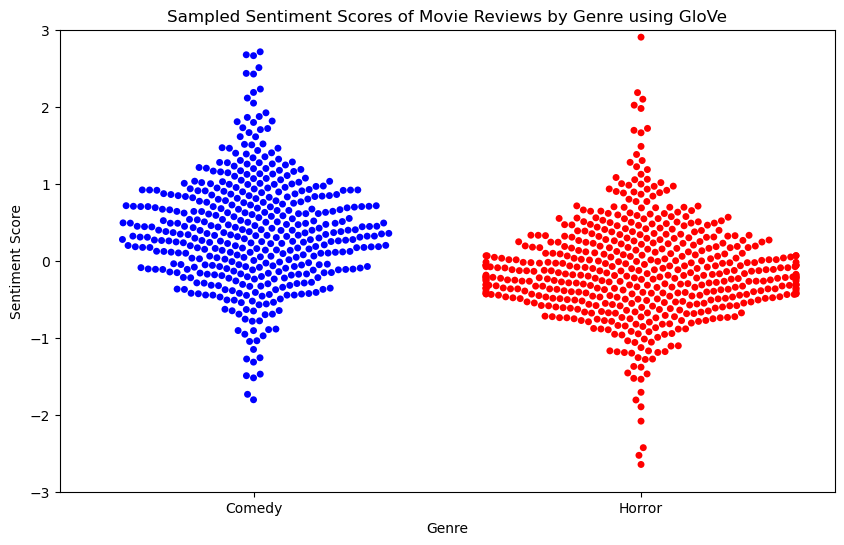

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add a new column to each DataFrame to distinguish genres
df_romcom_glove_trim['genre'] = 'Comedy'
df_horror_glove_trim['genre'] = 'Horror'

# Combine the two DataFrames into one
df_combined = pd.concat([df_romcom_glove_trim[['sentiment', 'genre']], df_horror_glove_trim[['sentiment', 'genre']]])

# Sample a subset of the data for plotting
df_sampled = df_combined.sample(n=1000, random_state=1)  # Adjust n as needed

# Plot the sampled data
plt.figure(figsize=(10, 6))
sns.swarmplot(x='genre', y='sentiment', data=df_sampled, palette={'Comedy': 'blue', 'Horror': 'red'})
plt.title('Sampled Sentiment Scores of Movie Reviews by Genre using GloVe')
plt.xlabel('Genre')
plt.ylabel('Sentiment Score')
plt.ylim(-3, 3) 

plt.show()

Based on the sample, comedy sentiment score  mean appears to be overall a bit higher than horror. But this may vary based on the sample. The swarm plot indicates the data for comedy has more values greater than 0 and more positive outlier values for comedy. Where as the negative tail of horror indicates there may be some reviews that had very high negative values. Overall the number of negative sentiments around or below 0 for horror seem to outweigh the positive sentiments.

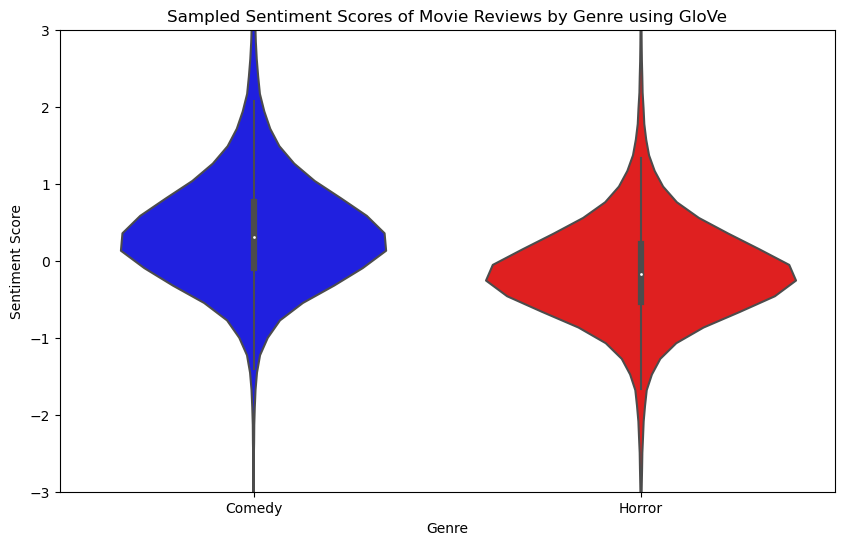

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add a new column to each DataFrame to distinguish genres
df_romcom_glove_trim['genre'] = 'Comedy'
df_horror_glove_trim['genre'] = 'Horror'

# Combine the two DataFrames into one
df_combined = pd.concat([df_romcom_glove_trim[['sentiment', 'genre']], df_horror_glove_trim[['sentiment', 'genre']]])

# Plot the sampled data
plt.figure(figsize=(10, 6))
sns.violinplot(x='genre', y='sentiment', data=df_combined, palette={'Comedy': 'blue', 'Horror': 'red'})
plt.title('Sampled Sentiment Scores of Movie Reviews by Genre using GloVe')
plt.xlabel('Genre')
plt.ylabel('Sentiment Score')
plt.ylim(-3, 3) 
plt.show()

The violin plot also indicates the mean vaue to be just above 0 for comedy and less tha 0 for horror. The breadth of the data around the mean for horror shows there are greater instances of sentiment scores hovering around the mean.

## Perform Similar Analysis with ConceptNet


In [ ]:
embeddings = load_embeddings('data/numberbatch-en-17.04b.txt')
embeddings.shape

#train the model
pos_words_common = list(set(pos_words) & set(embeddings.index)) 
neg_words_common = list(set(neg_words) & set(embeddings.index)) 

pos_vectors = embeddings.loc[pos_words_common]
neg_vectors = embeddings.loc[neg_words_common]
print(pos_vectors.shape,neg_vectors.shape)

#train the inputs and outputs
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

#prep for train test split
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

# create a linear classifier 
model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
model.fit(train_vectors, train_targets)
accuracy_score(model.predict(test_vectors), test_targets)

# Show 20 examples from the test set
words_to_sentiment(test_labels).iloc[:20]

#tokenize using regular expressions

TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


In [ ]:
# Apply the text_to_sentiment function to each review in the df_romcom DataFrame
df_romcom['sentiment'] = df_romcom['review'].apply(text_to_sentiment)

# Calculate the average sentiment for comedies
average_sentiment_comedy = df_romcom['sentiment'].mean()

# Apply the text_to_sentiment function to each review in the df_horror DataFrame
df_horror['sentiment'] = df_horror['review'].apply(text_to_sentiment)

# Calculate the average sentiment for horror movies
average_sentiment_horror = df_horror['sentiment'].mean()

# Print the average sentiments
print(f"Average Sentiment for Comedies: {average_sentiment_comedy}")
print(f"Average Sentiment for Horror Movies: {average_sentiment_horror}")

- Average Sentiment for Comedies: 0.029119482163650175
- Average Sentiment for Horror Movies: -0.20205652231804702

In [ ]:
df_romcom.to_csv('df_romcom_cnnb.csv', index=False)
df_horror.to_csv('df_horror_cnnb.csv', index=False)
df_romcom_cnnb_trim = df_romcom.drop(columns=['review'])
df_horror_cnnb_trim = df_horror.drop(columns=['review'])
df_romcom_cnnb_trim.to_csv('df_romcom_cnnb_trim.csv', index=False)
df_horror_cnnb_trim.to_csv('df_horror_cnnb_trim.csv', index=False)

C:\Users\chris\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


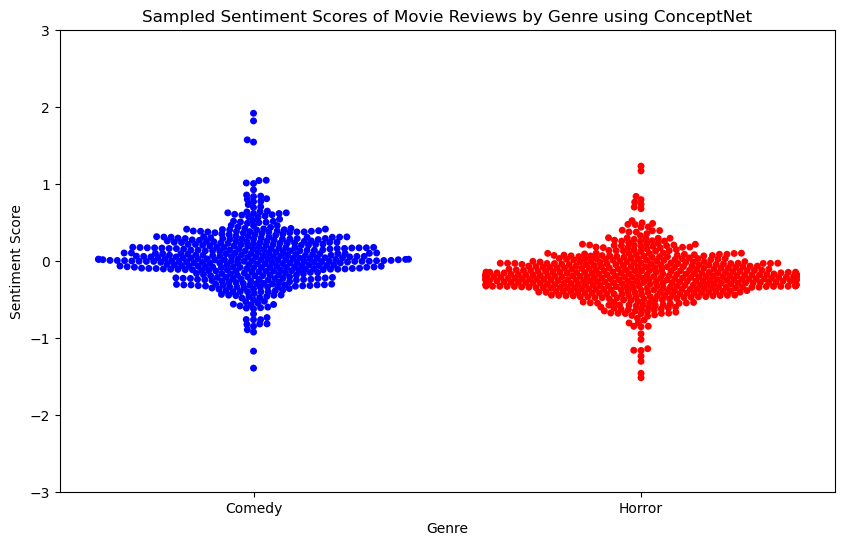

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add a new column to each DataFrame to distinguish genres
df_romcom_cnnb_trim['genre'] = 'Comedy'
df_horror_cnnb_trim['genre'] = 'Horror'

# Combine the two DataFrames into one
df_combined = pd.concat([df_romcom_cnnb_trim[['sentiment', 'genre']], df_horror_cnnb_trim[['sentiment', 'genre']]])

# Sample a subset of the data for plotting
df_sampled = df_combined.sample(n=1000, random_state=1)  # Adjust n as needed

# Plot the sampled data
plt.figure(figsize=(10, 6))
sns.swarmplot(x='genre', y='sentiment', data=df_sampled, palette={'Comedy': 'blue', 'Horror': 'red'})
plt.title('Sampled Sentiment Scores of Movie Reviews by Genre using ConceptNet')
plt.xlabel('Genre')
plt.ylabel('Sentiment Score')
plt.ylim(-3,3) 

plt.show()

ConceptNet data shows a lot of overlap between Comedy and GloVe embeddings. The mean of both appear to be very close to 0. The outliers of horror in is not as widespread as it is for Comedy indicating some much higher positive sentiment scores for comedy than horror as was expected. Overall the majority of the scores hover around 0 which I believe must indicate neutral sentiment.

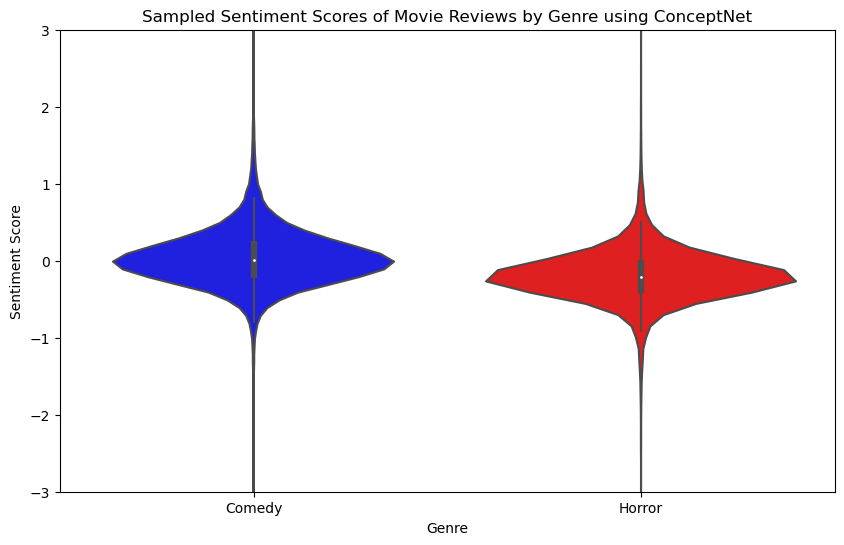

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add a new column to each DataFrame to distinguish genres
df_romcom_cnnb_trim['genre'] = 'Comedy'
df_horror_cnnb_trim['genre'] = 'Horror'

# Combine the two DataFrames into one
df_combined = pd.concat([df_romcom_cnnb_trim[['sentiment', 'genre']], df_horror_cnnb_trim[['sentiment', 'genre']]])

# Plot the sampled data
plt.figure(figsize=(10, 6))
sns.violinplot(x='genre', y='sentiment', data=df_combined, palette={'Comedy': 'blue', 'Horror': 'red'})
plt.title('Sampled Sentiment Scores of Movie Reviews by Genre using ConceptNet')
plt.xlabel('Genre')
plt.ylabel('Sentiment Score')
plt.ylim(-3,3) 

plt.show()

The violin plot visually confirms the means of both genres are much closer in ConceptNet than GloVe.

## Analysis

TODO: Add analysis - READ THIS PLEASE!
Suma's 2 cents: I looked at this section and rearranged some code so we could do some reuse.
 However, the normalized data has me very confused. If you look at the charts above this markdown entry, you see horror lagging behind comedy particulary in GloVe although not so much in ConceptNet. But after normalization, Horror has leapt up in mean sentiment score. Should we normalize ? I may very well be wrong here, I would like to hear back from you all on this. 

 

In [2]:
import pandas as pd
#Load GloVe Horror Results
df_horror_glove_trim = pd.read_csv('df_horror_glove_trim.csv', sep = ',')
df_horror_glove_trim.head()

,film name,year,genre,rating,sentiment
0,The Shining,1980,Drama Horror,rating,-0.981984
1,The Shining,1980,Drama Horror,Null,0.221749
2,The Shining,1980,Drama Horror,Null,0.520957
3,The Shining,1980,Drama Horror,Null,0.365487
4,The Shining,1980,Drama Horror,9,-0.084957


In [3]:
#Load GloVe RomCom Results
df_romcom_glove_trim = pd.read_csv('df_romcom_glove_trim.csv', sep = ',')
df_romcom_glove_trim.head()

,film name,year,genre,rating,sentiment
0,Guardians of the Galaxy,2014,Comedy,10,0.787825
1,Guardians of the Galaxy,2014,Comedy,9,2.014900
2,Guardians of the Galaxy,2014,Comedy,9,0.716487
3,Guardians of the Galaxy,2014,Comedy,9,1.347274
4,Guardians of the Galaxy,2014,Comedy,10,1.005797


In [4]:
#Load ConceptNet NumberBatch Horror Results
df_horror_cnnb_trim = pd.read_csv('df_horror_cnnb_trim.csv', sep = ',')
df_horror_cnnb_trim.head()

,film name,year,genre,rating,sentiment
0,The Shining,1980,Drama Horror,rating,0.905336
1,The Shining,1980,Drama Horror,Null,-0.048046
2,The Shining,1980,Drama Horror,Null,0.077248
3,The Shining,1980,Drama Horror,Null,-0.108780
4,The Shining,1980,Drama Horror,9,-0.291112


In [5]:
#Load ConceptNet NumberBatch RomCom Results
df_romcom_cnnb_trim = pd.read_csv('df_romcom_cnnb_trim.csv', sep = ',')
df_romcom_cnnb_trim.head()

,film name,year,genre,rating,sentiment
0,Guardians of the Galaxy,2014,Comedy,10,0.235207
1,Guardians of the Galaxy,2014,Comedy,9,0.975840
2,Guardians of the Galaxy,2014,Comedy,9,0.134740
3,Guardians of the Galaxy,2014,Comedy,9,0.293742
4,Guardians of the Galaxy,2014,Comedy,10,0.283084


#### Get some stats before Normalization


The null hypothesis is that there is no variance between the two genres. The alternate hypothesis is H1, that they are different. That the sentiment analysis is biased based on the genre. 


The following is a function that accepts a pandas dataframe, the embedding name, the sentiment score is the value of the independent factor which is genre for this dataset.

In [13]:
#F-stat, some part of this code was from https://www.geeksforgeeks.org/how-to-find-the-f-critical-value-in-python/
import scipy.stats as stats
import math
def calc_stats(this_df, embedding_name, value_column, groupby='genre'):
    
    fstat,pval = stats.f_oneway(
        this_df[value_column][this_df[groupby] == 'Comedy'],
        this_df[value_column][this_df[groupby] == 'Horror'],        
        )
    print()
    print('Embedding', embedding_name)
    print('-'*20)
    
    number_of_groups = 2 #comedy and horror
    numerator_degfreedom = -number_of_groups - 1
    denominator_degfreedom = len(this_df.index)-number_of_groups #numb of observations - number of groups
    alpha = 0.05 #significance level and since we are doing one tailed we dont divide this by 2

    fcritical = stats.f.ppf(q=1-0.05, dfn=numerator_degfreedom , dfd=denominator_degfreedom)
    
    print('F-statistic: ',fstat,' , p value:', pval, ', alpha:', alpha, ', f-critical:', fcritical )

    print('Analysis on ', value_column, ' results based on F-stat:')
    if math.isnan(fstat):
        print('  fstat cannot be used for comparision as it is nan')
    if math.isnan(fcritical):
        print('  fcritical cannot be used for comparision as it is nan')
    else:
        if fstat > fcritical:
            print('  F-stat is greater than f-critical : Reject the null hypothesis')
        else:
            print('  F-stat is less than f-critical : Fail to reject the null hypothesis')
    if math.isnan(pval):
        print('  p value cannot be used for comparision as it is nan')
    if pval < alpha:
        print('  p value is less than alpha : Reject the null hypothesis')
    else:
        print('  p value is greater than alpha : Fail to reject the null hypothesis')





In [12]:
#this needs to be done as genre is being used for grouping
df_romcom_glove_trim['genre'] = 'Comedy'
df_horror_glove_trim['genre'] = 'Horror'

df_romcom_cnnb_trim['genre'] = 'Comedy'
df_horror_cnnb_trim['genre'] = 'Horror'

df_temp_combined_glove = pd.concat([df_horror_glove_trim[['rating', 'sentiment', 'genre']], \
                                    df_romcom_glove_trim[['rating', 'sentiment', 'genre']]])
df_temp_combined_cnnb = pd.concat([df_horror_cnnb_trim[['rating', 'sentiment', 'genre']], \
                                    df_romcom_cnnb_trim[['rating', 'sentiment', 'genre']]])

calc_stats(df_temp_combined_glove,'GloVe', 'sentiment', 'genre')
calc_stats(df_temp_combined_cnnb,'ConceptNet', 'sentiment', 'genre')


Embedding GloVe
--------------------
F-statistic:  21130.21854990033  , p value: 0.0 , alpha: 0.05 , f-critical: nan
Analysis on  sentiment  results based on F-stat:
  fcritical cannot be used for comparision as it is nan
Based on p value: 
  p value is less than alpha : Reject the null hypothesis

Embedding ConceptNet
--------------------
F-statistic:  17701.91700236359  , p value: 0.0 , alpha: 0.05 , f-critical: nan
Analysis on  sentiment  results based on F-stat:
  fcritical cannot be used for comparision as it is nan
Based on p value: 
  p value is less than alpha : Reject the null hypothesis


Generally, the null hypothesis is that the variances between the groups being compared are equal. The alternate hypothesis is that sentiment scores should have significant difference in variances between the two populations (or genres).

Based on the statistical analysis above, the null hypothesis must be rejected. We chose 0.05 which is a typical alpha level. 

### Normalize sentiment between 0-1

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Apply the MinMaxScaler to the sentiment column of each DataFrame
df_horror_glove_trim['sentiment'] = scaler.fit_transform(df_horror_glove_trim[['sentiment']])
df_romcom_glove_trim['sentiment'] = scaler.fit_transform(df_romcom_glove_trim[['sentiment']])
df_horror_cnnb_trim['sentiment'] = scaler.fit_transform(df_horror_cnnb_trim[['sentiment']])
df_romcom_cnnb_trim['sentiment'] = scaler.fit_transform(df_romcom_cnnb_trim[['sentiment']])

# Print average sentiment for each genre
print('GloVe Horror Mean:', df_horror_glove_trim['sentiment'].mean())
print('GloVe RomCom Mean:', df_romcom_glove_trim['sentiment'].mean())
print('-'*40)
print('CNNB Horror Mean:', df_horror_cnnb_trim['sentiment'].mean())
print('CNNB RomCom Mean:', df_romcom_cnnb_trim['sentiment'].mean())

GloVe Horror Mean: 0.5718811725132873
GloVe RomCom Mean: 0.3826615472278381
----------------------------------------
CNNB Horror Mean: 0.4485250250185926
CNNB RomCom Mean: 0.4271889233914051


### Normalize rating between 0-1

In [34]:
# Try to convert each row's rating column to a float, removing any rows that can't be converted
df_horror_glove_trim['rating'] = pd.to_numeric(df_horror_glove_trim['rating'], errors='coerce')
df_horror_glove_trim = df_horror_glove_trim.dropna(subset=['rating'])

df_romcom_glove_trim['rating'] = pd.to_numeric(df_romcom_glove_trim['rating'], errors='coerce')
df_romcom_glove_trim = df_romcom_glove_trim.dropna(subset=['rating'])

df_horror_cnnb_trim['rating'] = pd.to_numeric(df_horror_cnnb_trim['rating'], errors='coerce')
df_horror_cnnb_trim = df_horror_cnnb_trim.dropna(subset=['rating'])

df_romcom_cnnb_trim['rating'] = pd.to_numeric(df_romcom_cnnb_trim['rating'], errors='coerce')
df_romcom_cnnb_trim = df_romcom_cnnb_trim.dropna(subset=['rating'])

# Normalize the rating column for each DataFrame
df_horror_glove_trim['rating'] = scaler.fit_transform(df_horror_glove_trim[['rating']])
df_romcom_glove_trim['rating'] = scaler.fit_transform(df_romcom_glove_trim[['rating']])
df_horror_cnnb_trim['rating'] = scaler.fit_transform(df_horror_cnnb_trim[['rating']])
df_romcom_cnnb_trim['rating'] = scaler.fit_transform(df_romcom_cnnb_trim[['rating']])

# Print the average rating for each genre
print('Horror Rating Mean:', df_horror_glove_trim['rating'].mean())
print('RomCom Rating Mean:', df_romcom_glove_trim['rating'].mean())

Horror Rating Mean: 0.5961701808563579
RomCom Rating Mean: 0.7151733683323913


### Adding delta column

In [35]:
# Add a new column to each DataFrame to find the delta between sentiment and rating
df_romcom_glove_trim['delta'] = df_romcom_glove_trim['sentiment'] - df_romcom_glove_trim['rating']
df_horror_glove_trim['delta'] = df_horror_glove_trim['sentiment'] - df_horror_glove_trim['rating']
df_romcom_cnnb_trim['delta'] = df_romcom_cnnb_trim['sentiment'] - df_romcom_cnnb_trim['rating']
df_horror_cnnb_trim['delta'] = df_horror_cnnb_trim['sentiment'] - df_horror_cnnb_trim['rating']

# Print the average delta for each genre
print('GloVe Horror Delta Mean:', df_horror_glove_trim['delta'].mean())
print('GloVe RomCom Delta Mean:', df_romcom_glove_trim['delta'].mean())
print('-'*40)
print('CNNB Horror Delta Mean:', df_horror_cnnb_trim['delta'].mean())
print('CNNB RomCom Delta Mean:', df_romcom_cnnb_trim['delta'].mean())

GloVe Horror Delta Mean: -0.02416377419319859
GloVe RomCom Delta Mean: -0.3321198716290746
----------------------------------------
CNNB Horror Delta Mean: -0.14766581058356928
CNNB RomCom Delta Mean: -0.28774400027024627


### Prepare data for plotting 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Review Rating
# Add a new column to each DataFrame to distinguish genres
df_romcom_cnnb_trim['genre'] = 'Comedy'
df_horror_cnnb_trim['genre'] = 'Horror'

#NOTE :Suma modified the code some to maintain data integrity and increase code reuse
# Combine the two DataFrames into one
df_cnnb_combined = pd.concat([df_romcom_cnnb_trim[['rating', 'sentiment', 'genre', 'delta']], df_horror_cnnb_trim[['rating','sentiment', 'genre', 'delta']]])

# Sample a subset of the data for plotting
df_cnnb_sampled = df_cnnb_combined.sample(n=1000, random_state=1)  # Adjust n as needed

## GloVe
# Add a new column to each DataFrame to distinguish genres
df_romcom_glove_trim['genre'] = 'Comedy'
df_horror_glove_trim['genre'] = 'Horror'

# Combine the two DataFrames into one
df_glove_combined = pd.concat([df_romcom_glove_trim[['rating', 'sentiment', 'genre', 'delta']], df_horror_glove_trim[['rating','sentiment', 'genre', 'delta']]])

# Sample a subset of the data for plotting
df_glove_sampled = df_glove_combined.sample(n=1000, random_state=1)  # Adjust n as needed

## Plot Normalized Sentiments and Ratings

C:\Users\schack\AppData\Local\Temp\ipykernel_11176\2714698908.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(ax=axes[0], x='genre', y='rating', data=df_cnnb_sampled, palette={'Comedy': 'blue', 'Horror': 'red'})
C:\Users\schack\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\schack\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:3398: UserWarning: 55.2% of the points cannot be placed; you 

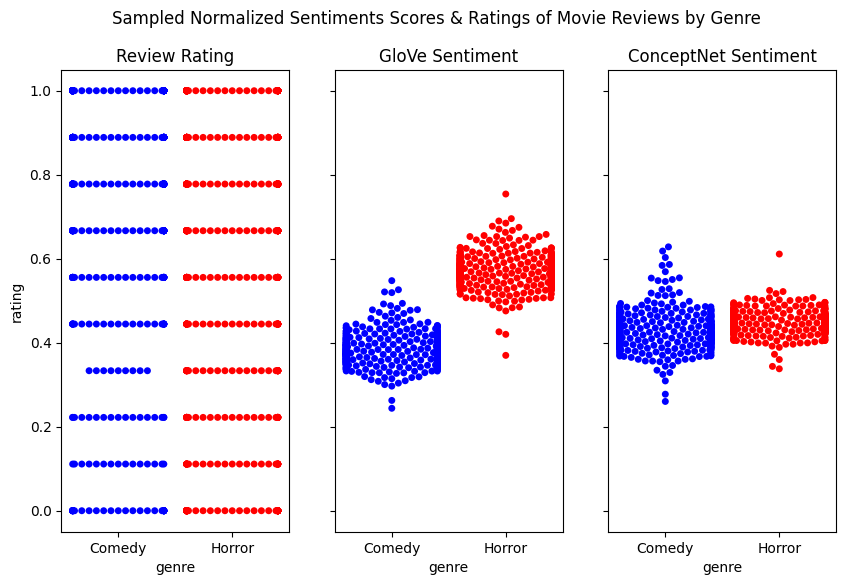

In [36]:
#Create a Swarm plot
fig, axes = plt.subplots(1, 3, figsize=(10,6), sharey=True)
fig.suptitle('Sampled Normalized Sentiments Scores & Ratings of Movie Reviews by Genre')

# Plot the sampled CNNB data for rating
sns.swarmplot(ax=axes[0], x='genre', y='rating', data=df_cnnb_sampled, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[0].set_title('Review Rating')

# Plot the sampled Glove data for sentiment
sns.swarmplot(ax=axes[1], x='genre', y='sentiment', data=df_glove_sampled, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[1].set_title('GloVe Sentiment')

## ConceptNet
# Plot the sampled ConcepNet data for sentiment
sns.swarmplot(ax=axes[2], x='genre', y='sentiment', data=df_cnnb_sampled, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[2].set_title('ConceptNet Sentiment')

plt.show()

C:\Users\schack\AppData\Local\Temp\ipykernel_11176\3194767795.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[0], x='genre', y='rating', data=df_cnnb_combined, palette={'Comedy': 'blue', 'Horror': 'red'})
C:\Users\schack\AppData\Local\Temp\ipykernel_11176\3194767795.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[1], x='genre', y='sentiment', data=df_glove_combined, palette={'Comedy': 'blue', 'Horror': 'red'})
C:\Users\schack\AppData\Local\Temp\ipykernel_11176\3194767795.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



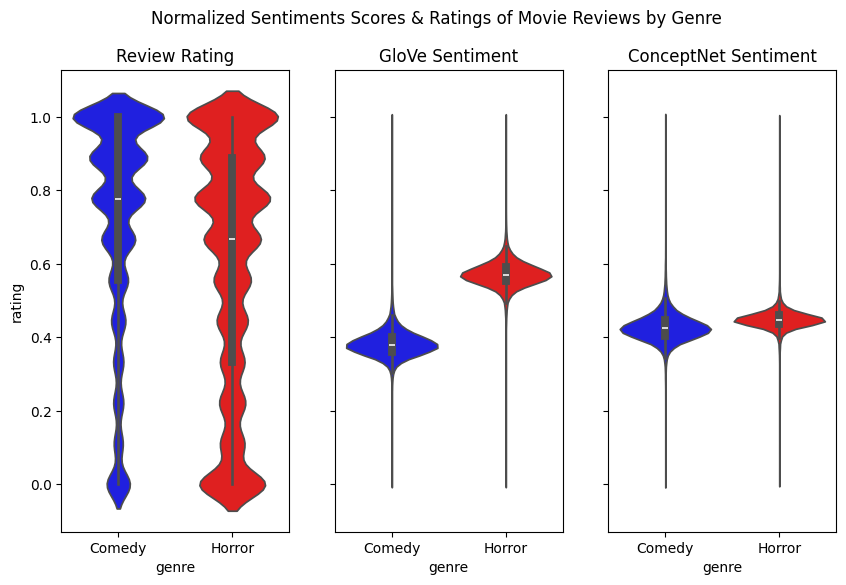

In [37]:
## Doing the same but with Violin Plots and against the entire dataset not just sampled

fig, axes = plt.subplots(1, 3, figsize=(10,6), sharey=True)
fig.suptitle('Normalized Sentiments Scores & Ratings of Movie Reviews by Genre')

## Review Rating
# Plot the data

sns.violinplot(ax=axes[0], x='genre', y='rating', data=df_cnnb_combined, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[0].set_title('Review Rating')

## GloVe
# Plot the data
sns.violinplot(ax=axes[1], x='genre', y='sentiment', data=df_glove_combined, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[1].set_title('GloVe Sentiment')

## ConceptNet
# Plot the data
sns.violinplot(ax=axes[2], x='genre', y='sentiment', data=df_cnnb_combined, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[2].set_title('ConceptNet Sentiment')

plt.show()

### Plotting the Delta columns

C:\Users\schack\AppData\Local\Temp\ipykernel_11176\3450579930.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[0], x='genre', y='delta', data=df_glove_combined, palette={'Comedy': 'blue', 'Horror': 'red'})
C:\Users\schack\AppData\Local\Temp\ipykernel_11176\3450579930.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[1], x='genre', y='delta', data=df_cnnb_combined, palette={'Comedy': 'blue', 'Horror': 'red'})


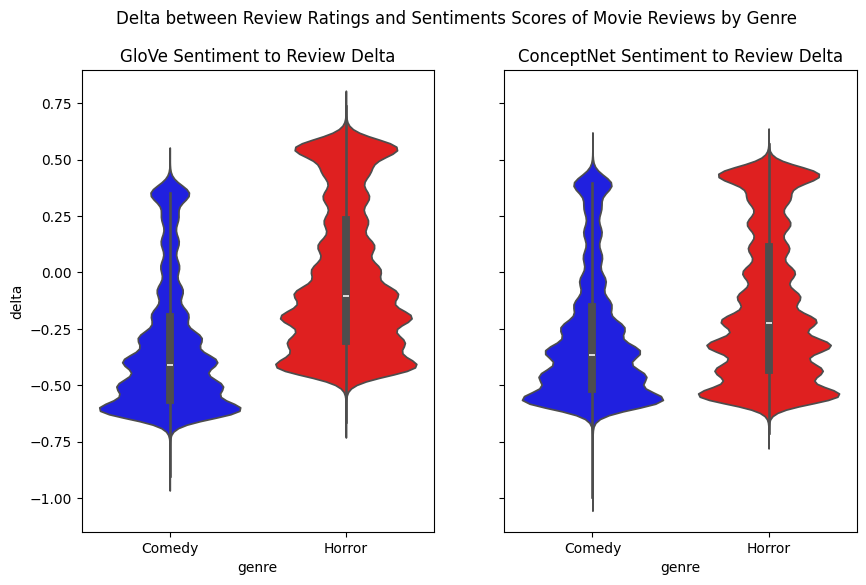

In [38]:
## Plotting the Delta columns
fig, axes = plt.subplots(1, 2, figsize=(10,6), sharey=True)
fig.suptitle('Delta between Review Ratings and Sentiments Scores of Movie Reviews by Genre')

## GloVe
# Plot the data
sns.violinplot(ax=axes[0], x='genre', y='delta', data=df_glove_combined, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[0].set_title('GloVe Sentiment to Review Delta')

## ConceptNet
# Plot the data
sns.violinplot(ax=axes[1], x='genre', y='delta', data=df_cnnb_combined, palette={'Comedy': 'blue', 'Horror': 'red'})
axes[1].set_title('ConceptNet Sentiment to Review Delta')

plt.show()

#### Repeating the F stat on normalized data


In [67]:


calc_stats(df_glove_combined, 'GloVe', 'sentiment', 'genre')
calc_stats(df_cnnb_combined, 'ConceptNet', 'sentiment', 'genre')




Embedding GloVe
--------------------
F-statistic:  1054152.7931943827  , p value: 0.0 , alpha: 0.05 , f-critical: nan
Analysis on  sentiment  results based on F-stat:
  fcritical cannot be used for comparision as it is nan
Based on p value: 
  p value is less than alpha : Reject the null hypothesis

Embedding ConceptNet
--------------------
F-statistic:  16668.354307641515  , p value: 0.0 , alpha: 0.05 , f-critical: nan
Analysis on  sentiment  results based on F-stat:
  fcritical cannot be used for comparision as it is nan
Based on p value: 
  p value is less than alpha : Reject the null hypothesis


Based on the statistical analysis, the null hypothesis must be rejected even for normalized data. We chose 0.05 which is a typical alpha level.



## Conclusion

TODO: Add conclusion

Identify two conferences or journals that would be interested in the results of your analysis.  

## References